Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking
using CmdStan, StanMCMCChain
gr(size=(500,500));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "chapters", "05")
cd(ProjDir)

### snippet 5.1

In [3]:
wd = CSV.read(joinpath(dirname(Base.pathof(StatisticalRethinking)), "..",
  "data", "WaffleDivorce.csv"), delim=';')
df = convert(DataFrame, wd);
mean_ma = mean(df[:MedianAgeMarriage])
df[:MedianAgeMarriage] = convert(Vector{Float64},
  df[:MedianAgeMarriage]) .- mean_ma;
# Define the Stan language model
ad_model = "
data {
 int < lower = 1 > N; // Sample size
 vector[N] divorce; // Predictor
 vector[N] median_age; // Outcome
}

parameters {
 real a; // Intercept
 real bA; // Slope (regression coefficients)
 real < lower = 0 > sigma; // Error SD
}

transformed parameters {
  vector[N] mu; // Intermediate mu
  for (i in 1:N)
    mu[i] = a + bA*median_age[i];
}

model {
  # priors
  a ~ normal(10, 10);
  bA ~ normal(0, 1);
  sigma ~ uniform(0, 10);
  # model
  divorce ~ normal(mu , sigma);
}

generated quantities {
}
";

Define the Stanmodel and set the output format to :mcmcchain.

In [4]:
stanmodel = Stanmodel(name="MedianAgeDivorce", monitors = ["a", "bA", "sigma"],
  model=ad_model, output_format=:mcmcchain);
# Input data for cmdstan
maddata = [
  Dict("N" => length(df[:Divorce]), "divorce" => df[:Divorce],
    "median_age" => df[:MedianAgeMarriage])
];

=====> /Users/rob/.julia/dev/StatisticalRethinking/chapters/05


File /Users/rob/.julia/dev/StatisticalRethinking/chapters/05/tmp/MedianAgeDivorce.stan will be updated.



Sample using cmdstan

In [5]:
rc, chn, cnames = stan(stanmodel, maddata, ProjDir, diagnostics=false,
  CmdStanDir=CMDSTAN_HOME);
# Describe the draws
describe(chn)



--- Translating Stan model to C++ code ---
bin/stanc  /Users/rob/.julia/dev/StatisticalRethinking/chapters/05/tmp/MedianAgeDivorce.stan --o=/Users/rob/.julia/dev/StatisticalRethinking/chapters/05/tmp/MedianAgeDivorce.hpp
Model name=MedianAgeDivorce_model
Input file=/Users/rob/.julia/dev/StatisticalRethinking/chapters/05/tmp/MedianAgeDivorce.stan
Output file=/Users/rob/.julia/dev/StatisticalRethinking/chapters/05/tmp/MedianAgeDivorce.hpp

--- Linking C++ model ---
clang++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.66.0 -isystem stan/lib/stan_math/lib/sundials_3.1.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -Wno-unused-function -Wno-uninitialized -I src -isystem stan/src -isystem stan/lib/stan_math/ -DFUSION_MAX_VECTOR_SIZE=12 -Wno-unused-local-typedefs -DEIGEN_NO_DEBUG -DNO_FPRINTF_OUTPUT -pipe   src/cmdstan/main.cpp  -O3 -o /Users/rob/.julia/dev/St

Plot the density of posterior draws

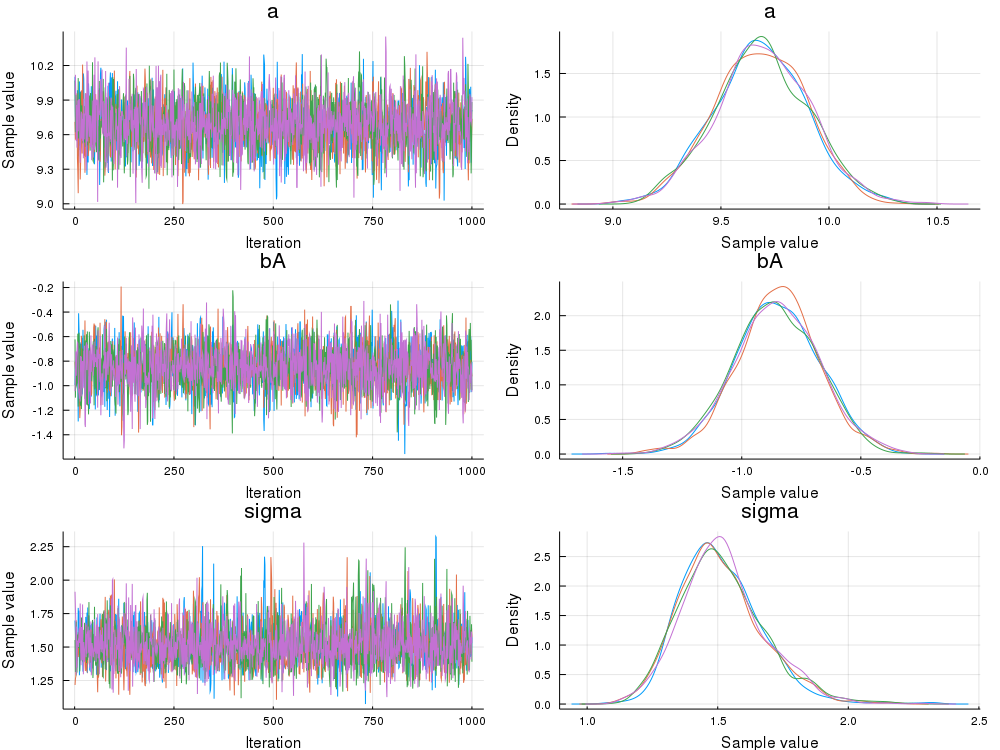

In [6]:
plot(chn)

Plot regression line using means and observations

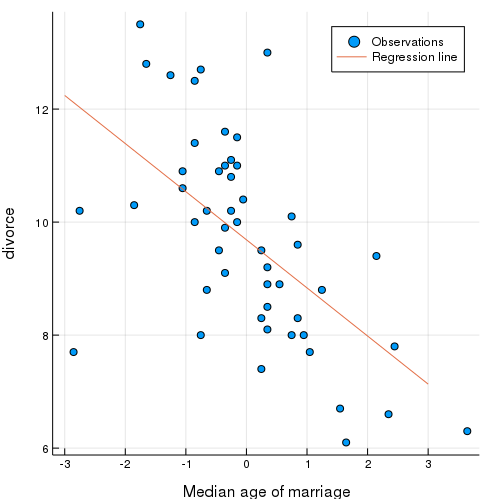

In [7]:
xi = -3.0:0.1:3.0
rws, vars, chns = size(chn[:, 1, :])
alpha_vals = convert(Vector{Float64}, reshape(chn.value[:, 1, :], (rws*chns)))
beta_vals = convert(Vector{Float64}, reshape(chn.value[:, 2, :], (rws*chns)))
yi = mean(alpha_vals) .+ mean(beta_vals)*xi

scatter(df[:MedianAgeMarriage], df[:Divorce], lab="Observations",
  xlab="Median age of marriage", ylab="divorce")
plot!(xi, yi, lab="Regression line")

Plot estimates using the N = [10, 50, 150, 352] observations


make: `/Users/rob/.julia/dev/StatisticalRethinking/chapters/05/tmp/MedianAgeDivorce' is up to date.

Length of data array is not equal to nchains,
all chains will use the first data dictionary.

make: `/Users/rob/.julia/dev/StatisticalRethinking/chapters/05/tmp/MedianAgeDivorce' is up to date.

Length of data array is not equal to nchains,
all chains will use the first data dictionary.

make: `/Users/rob/.julia/dev/StatisticalRethinking/chapters/05/tmp/MedianAgeDivorce' is up to date.

Length of data array is not equal to nchains,
all chains will use the first data dictionary.

make: `/Users/rob/.julia/dev/StatisticalRethinking/chapters/05/tmp/MedianAgeDivorce' is up to date.

Length of data array is not equal to nchains,
all chains will use the first data dictionary.


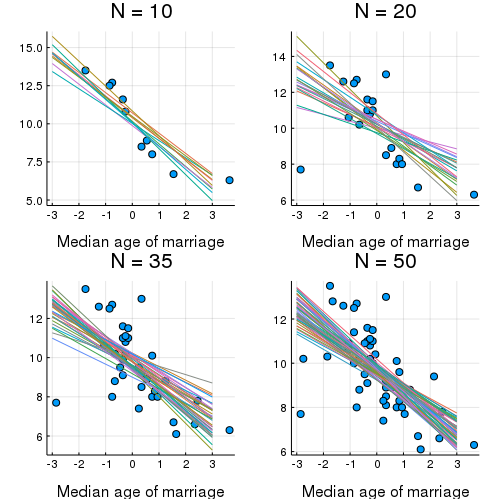

In [8]:
p = Vector{Plots.Plot{Plots.GRBackend}}(undef, 4)
nvals = [10, 20, 35, 50]

for i in 1:length(nvals)
  N = nvals[i]
  maddataN = [
    Dict("N" => N, "divorce" => df[1:N, :Divorce],
      "median_age" => df[1:N, :MedianAgeMarriage])
  ]
  rc, chnN, cnames = stan(stanmodel, maddataN, ProjDir, diagnostics=false,
    summary=false, CmdStanDir=CMDSTAN_HOME)

  xi = -3.0:0.1:3.0
  rws, vars, chns = size(chnN[:, 1, :])
  alpha_vals = convert(Vector{Float64}, reshape(chnN.value[:, 1, :], (rws*chns)))
  beta_vals = convert(Vector{Float64}, reshape(chnN.value[:, 2, :], (rws*chns)))

  p[i] = scatter(df[1:N, :MedianAgeMarriage], df[1:N, :Divorce],
    leg=false, xlab="Median age of marriage")
  for j in 1:N
    yi = alpha_vals[j] .+ beta_vals[j]*xi
    plot!(p[i], xi, yi, title="N = $N")
  end
end
plot(p..., layout=(2, 2))

End of `05/clip_01s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*